RFM анализ - метод сегментации клиентской базы на основании 3 измерений: количества транзакций, объема транзакций и последней даты транзакции. 
Данный Notebook подготовлен для слушателей первого митапа продуктовых аналитиков в Казахстане - https://altel.timepad.ru/event/3079633/ 

Notebook содержит RFM анализ с возможностью гибкой настройки логики разбиения на группы. Адаптируя анализ к своему бизнесу, вы сможете самостоятельно установить, по какому принципу будут формироваться трешхолды для каждого из измерений. Более того, анализ содержит расширение сегментации за счет добавления четвертого измерения - никлона линии тренда транзакционной активности каждого клиента. 

Ссылка на готовый пакет стороннего автора, упомянутый в презентации: https://github.com/sonwanesuresh95/rfm/blob/main/README.md 

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress

In [34]:
df = pd.read_excel('data_for_rfm.xlsx')
df.head(2)

,Unnamed: 0,customer_id,recency,frequency,amount
0,0,635735279cb00c53cc7dec10b91a5f09f710cad2138c86...,479,5,5.442418
1,1,64b5d15e2587cd1296c73a6f7be600f2db6dc8df85b391...,94,4,3.401197


In [62]:
# Этот датафрейм понадобится нам для определения тренда. 
# Переменные в нем: m - месяц, frequency - количество транзакций, m_cnt - количество месяцев с транзакцией у пользователя, m_num - порядковый номер месяца

trx_for_trends_df = pd.read_excel('data_for_trends.xlsx')
trx_for_trends_df.head(2)

,Unnamed: 0,customer_id,m,frequency,m_cnt,m_num
0,0,64b5d15e2587cd1296c73a6f7be600f2db6dc8df85b391...,2020-11-01,1,2,1
1,1,64b5d15e2587cd1296c73a6f7be600f2db6dc8df85b391...,2021-05-01,2,2,2


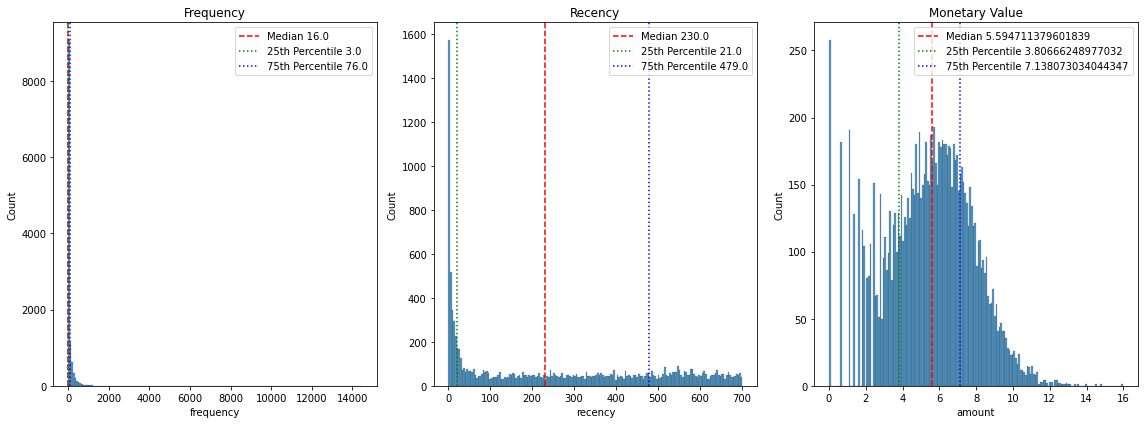

In [36]:
# Блок кода для изучения распределений с наложением статистических метрик 
# Такой вариант отображения статистик на графиках может понадобится вам и для других задач, он очень наглядно показывает метрики распределения 

median_frequency = df['frequency'].median()
percentile_25_frequency = np.percentile(df['frequency'], 25)
percentile_75_frequency = np.percentile(df['frequency'], 75)

median_recency = df['recency'].median()
percentile_25_recency = np.percentile(df['recency'], 25)
percentile_75_recency = np.percentile(df['recency'], 75)

median_amount = df['amount'].median()
percentile_25_amount = np.percentile(df['amount'], 25)
percentile_75_amount = np.percentile(df['amount'], 75)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(df['frequency'], bins=180, ax=axes[0])
axes[0].set_title('Frequency')
axes[0].axvline(median_frequency, color='r', linestyle='--', label=f'Median {median_frequency}')
axes[0].axvline(percentile_25_frequency, color='g', linestyle=':', label=f'25th Percentile {percentile_25_frequency}')
axes[0].axvline(percentile_75_frequency, color='b', linestyle=':', label=f'75th Percentile {percentile_75_frequency}')
axes[0].legend()

sns.histplot(df['recency'], bins=180, ax=axes[1])
axes[1].set_title('Recency')
axes[1].axvline(median_recency, color='r', linestyle='--', label=f'Median {median_recency}')
axes[1].axvline(percentile_25_recency, color='g', linestyle=':', label=f'25th Percentile {percentile_25_recency}')
axes[1].axvline(percentile_75_recency, color='b', linestyle=':', label=f'75th Percentile {percentile_75_recency}')
axes[1].legend()

sns.histplot(df['amount'], bins=180, ax=axes[2])
axes[2].set_title('Monetary Value')
axes[2].axvline(median_amount, color='r', linestyle='--', label=f'Median {median_amount}')
axes[2].axvline(percentile_25_amount, color='g', linestyle=':', label=f'25th Percentile {percentile_25_amount}')
axes[2].axvline(percentile_75_amount, color='b', linestyle=':', label=f'75th Percentile {percentile_75_amount}')
axes[2].legend()

plt.tight_layout()
plt.show()

In [37]:
# Блок кода с самим разбиением на сегменты. Пользователи по recency делятся на 4 группы, остальные - на 3. 
# Все категории грейдируются в порядке убывания - чем привлекательнее значение метрики, тем меньшее числовое значение (сегмент) будет присвоено

df['r'] = pd.cut(df['recency'], bins=[-np.inf, 30, 60, 90, np.inf], labels=[1,2,3,4])
df['f'] = pd.cut(df['frequency'], bins=[-np.inf, percentile_25_frequency, percentile_75_frequency, np.inf], labels=[3, 2, 1])
df['m'] = pd.cut(df['amount'], bins=[-np.inf, percentile_25_amount, percentile_75_amount, np.inf], labels=[3, 2, 1])

In [38]:
# Блок кода с присвоением текстовых категорий с дополнительной информацией сегментам. Такая текстовая интерпетация с включенными переменными - значениями статистик 
# значительно облегчит интерпретацию бизнес-юниту. 

df['r_desc'] = df['r'].apply(lambda x: 'Недавно покупавшие ' if x == 1 else ('Спящие ' if x == 2 else ('Уходящие ' if x == 3 else 'Ушедшие ')))

df['f_desc'] = df['f'].apply(lambda x: f'С числом транзакций свыше {percentile_75_frequency}' if x == 1 else 
                                    (f'С числом транзакций свыше {percentile_25_frequency} но менее {percentile_75_frequency}' if x == 2 else 
                                    f'С числом транзакций {percentile_25_frequency} или менее'))

df['m_desc'] = df['m'].apply(lambda x: f' и суммой свыше {percentile_75_amount} сумм' if x == 1 else 
                                    (f' и суммой свыше {percentile_25_amount} но менее {percentile_75_amount} сумм' if x == 2 else 
                                    f' и суммой {percentile_25_amount} сумм и менее'))

In [39]:
# Смотрим, что интересного у нас получилось в переменных x_desc 

df.head(2)

,Unnamed: 0,customer_id,recency,frequency,amount,r,f,m,r_desc,f_desc,m_desc
0,0,635735279cb00c53cc7dec10b91a5f09f710cad2138c86...,479,5,5.442418,4,2,2,Ушедшие,С числом транзакций свыше 3.0 но менее 76.0,и суммой свыше 3.80666248977032 но менее 7.13...
1,1,64b5d15e2587cd1296c73a6f7be600f2db6dc8df85b391...,94,4,3.401197,4,2,3,Ушедшие,С числом транзакций свыше 3.0 но менее 76.0,и суммой 3.80666248977032 сумм и менее


In [40]:
# Функция присвоения категорий. Каждая строка имеет фиксированный r и повторяющуюся логику дял f и m при каждой r. 

def categorize_users(df):
    categories = []

    for index, row in df.iterrows():
        r, f, m = int(row['r']), int(row['f']), int(row['m'])

        if r == 1 and f == 1 and m == 1:
            category = 'VIP'
        elif r == 1 and f in [1, 2] and m in [1, 2]:
            category = 'Выгодные'
        elif r == 1 and f == 3 and m == 3:
            category = 'С низкой активностью'
        elif r == 1 and f in [1, 2, 3] and m in [1, 2, 3]:
            category = 'Потенциально выгодные'
        elif r == 2 and f in [1, 2] and m in [1, 2]:
            category = 'Спящие выгодные'
        elif r == 2 and f == 3 and m == 3:
            category = 'Спящие с низкой активностью'
        elif r == 2 and f in [1, 2, 3] and m in [1, 2, 3]:
            category = 'Спящие'
        elif r == 3 and f in [1, 2] and m in [1, 2]:
            category = 'Уходящие выгодные'
        elif r == 3 and f == 3 and m == 3:
            category = 'Уходящие с низкой активностью'
        elif r == 3 and f in [1, 2, 3] and m in [1, 2, 3]:
            category = 'Уходящие'
        else:
            category = 'Ушедшие'

        categories.append(category)

    df['Category'] = categories
    return df

In [41]:
# Применение функции.

users_categorized_df = categorize_users(df) 

In [79]:
# Изменение типов данных для столбцов с datatype category для дальнейшей конкатенации для получения сегмента на основе пересечений 3 измерений. 

columns_to_convert = ['r', 'f', 'm', 'r_desc', 'f_desc', 'm_desc']
users_categorized_df[columns_to_convert] = users_categorized_df[columns_to_convert].astype(str)

In [43]:
users_categorized_df['rfm'] = users_categorized_df['r'] + users_categorized_df['f'] + users_categorized_df['m']
users_categorized_df['segment'] = users_categorized_df['r_desc'] + users_categorized_df['f_desc'] + users_categorized_df['m_desc']
user_rfm_segm_df = users_categorized_df[['customer_id','Category','segment']]

In [44]:
user_rfm_segm_df.head(2)

,customer_id,Category,segment
0,635735279cb00c53cc7dec10b91a5f09f710cad2138c86...,Ушедшие,Ушедшие С числом транзакций свыше 3.0 но менее...
1,64b5d15e2587cd1296c73a6f7be600f2db6dc8df85b391...,Ушедшие,Ушедшие С числом транзакций свыше 3.0 но менее...


In [45]:
# Считаем количество пользователей в категориях
rfm_cat = user_rfm_segm_df.groupby(['Category']).size().reset_index(name='customers')

In [46]:
rfm_cat.head(2)

,Category,customers
0,VIP,1192
1,Выгодные,1596


In [47]:
# Считаем количество пользователей в сегментах
rfm_seg = user_rfm_segm_df.groupby(['Category', 'segment']).size().reset_index(name='customers')

In [48]:
rfm_seg.head(2)

,Category,segment,customers
0,VIP,Недавно покупавшие С числом транзакций свыше 7...,1192
1,Выгодные,Недавно покупавшие С числом транзакций свыше 3...,952


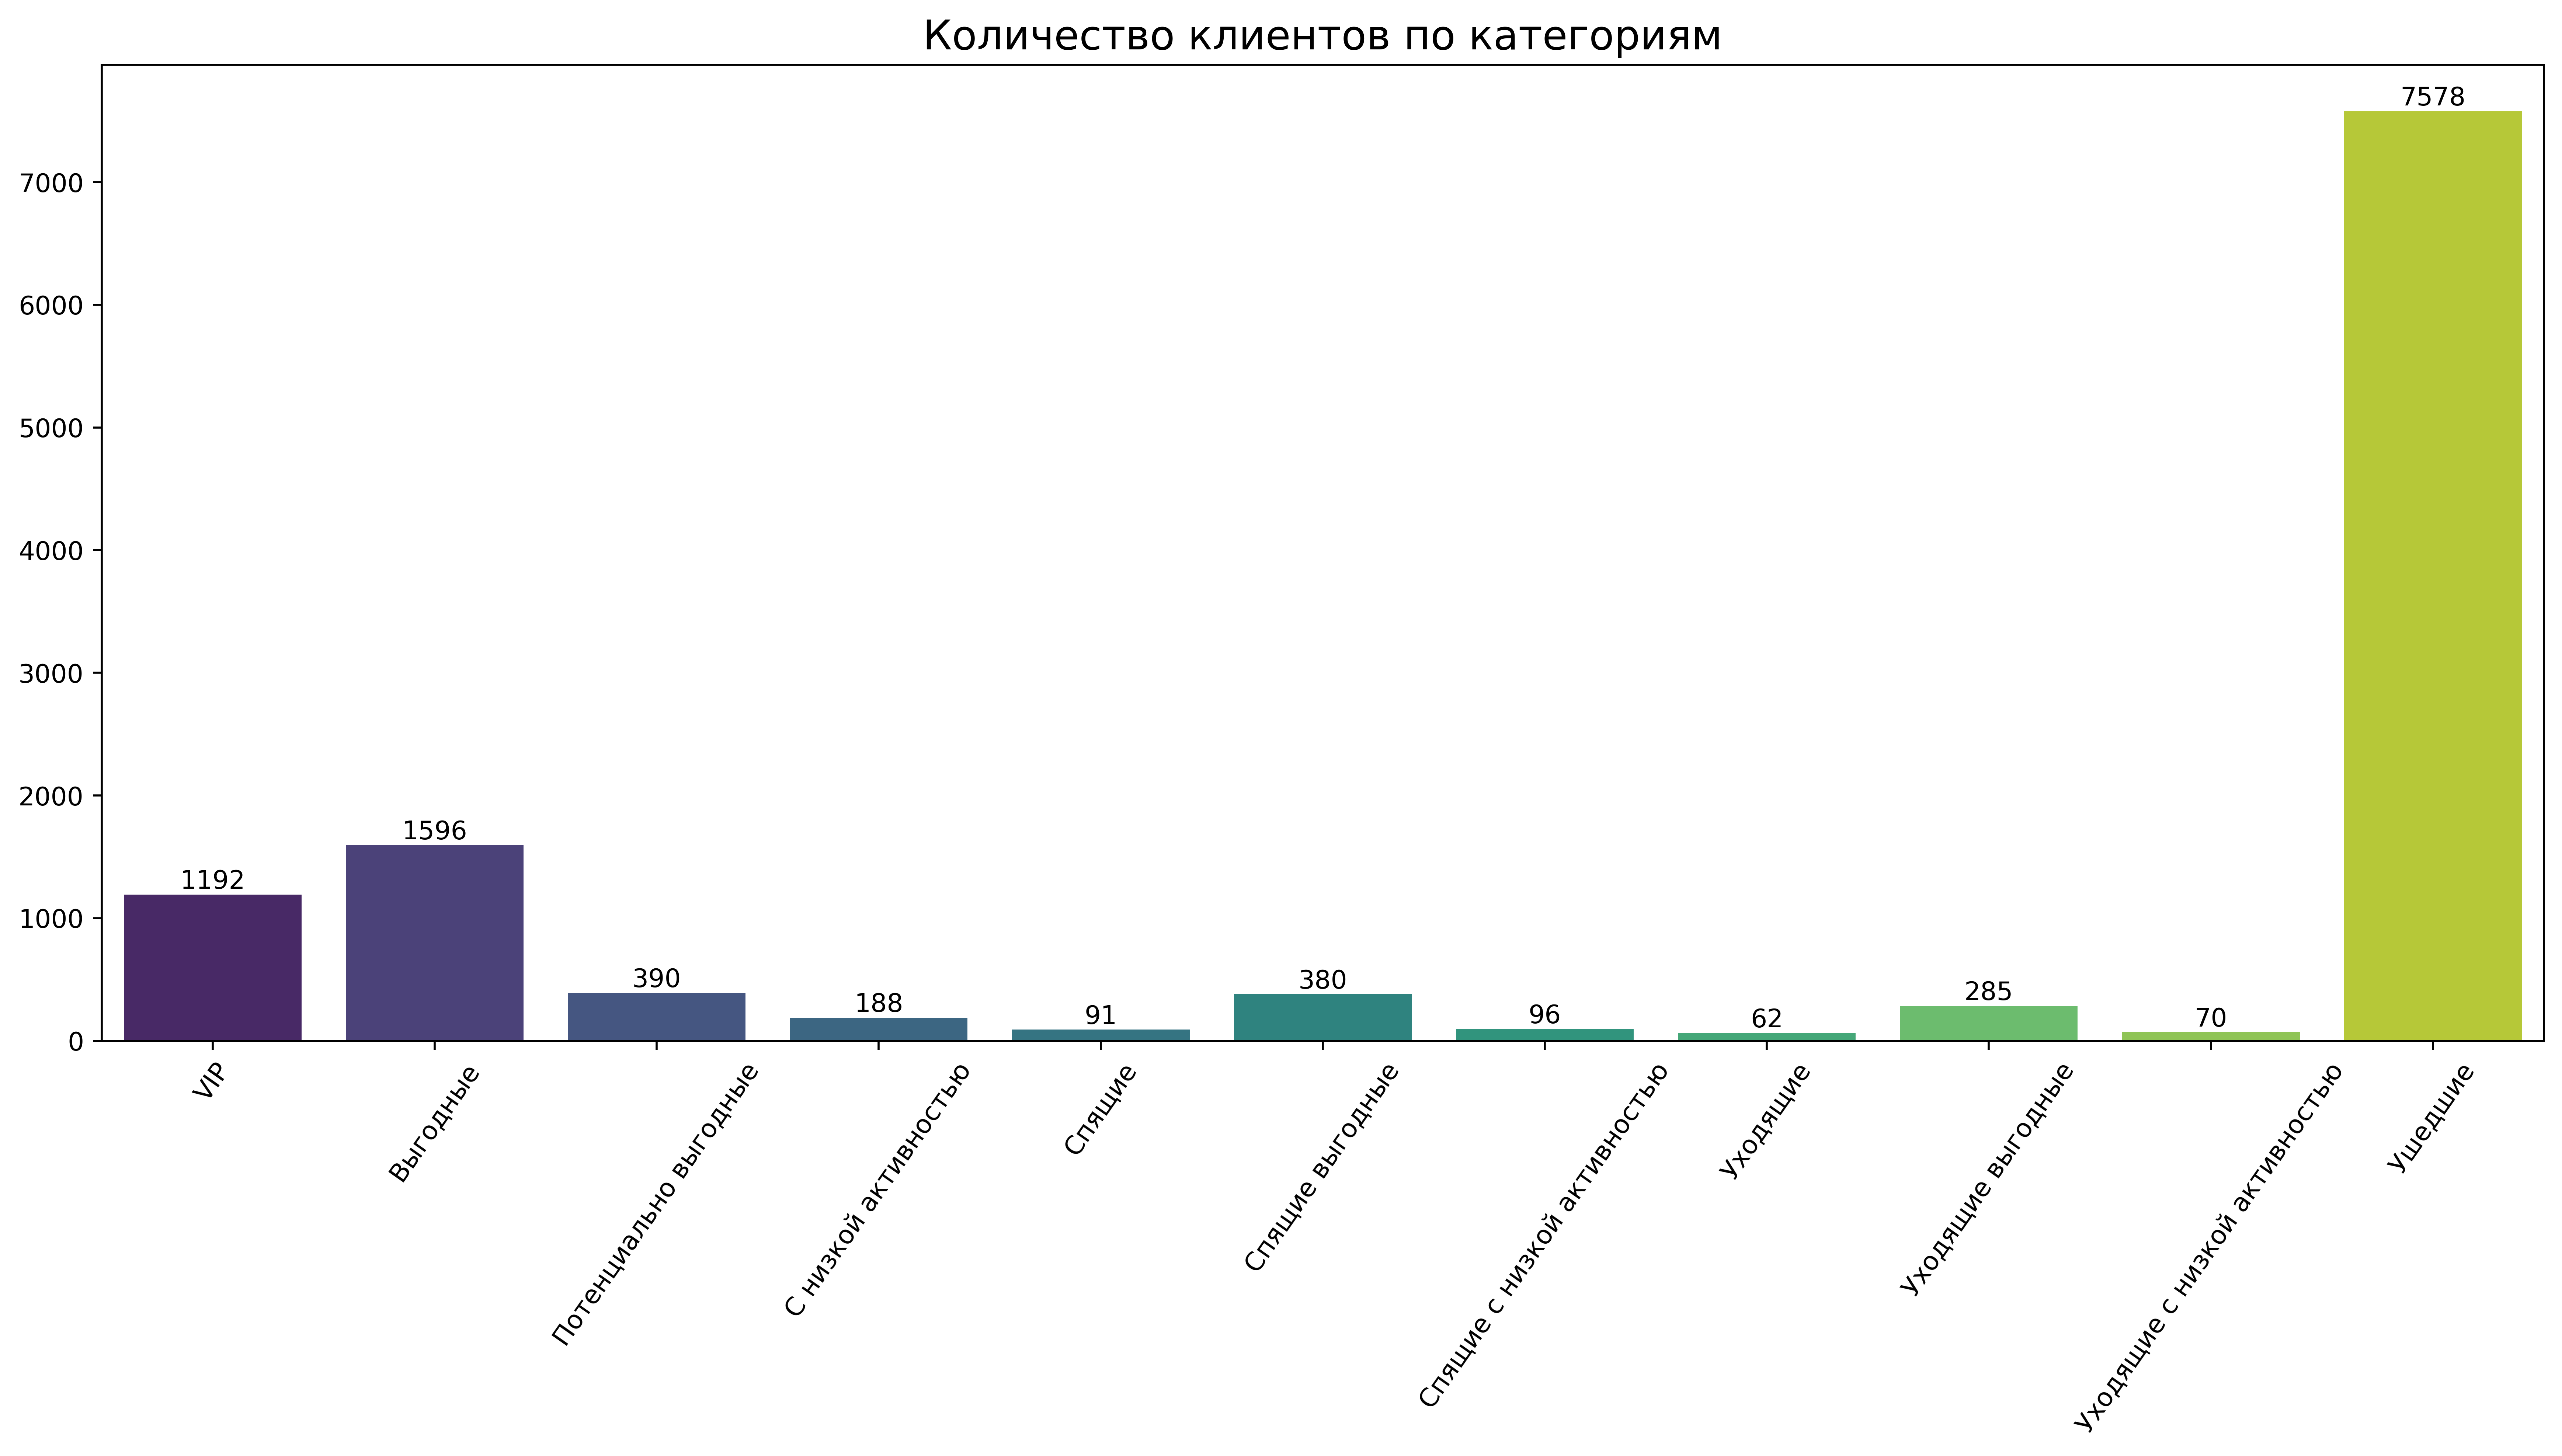

In [49]:
# Вихуализация категорий

plt.figure(figsize=(14, 8),dpi=500)
ax = sns.barplot(data=rfm_cat, x='Category', y='customers', palette='viridis')
plt.title('Количество клиентов по категориям', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xticks(rotation=55, fontsize=10)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 5, '%d' % int(p.get_height()),
            fontsize=10, ha='center', va='bottom')

plt.tight_layout()
plt.show()

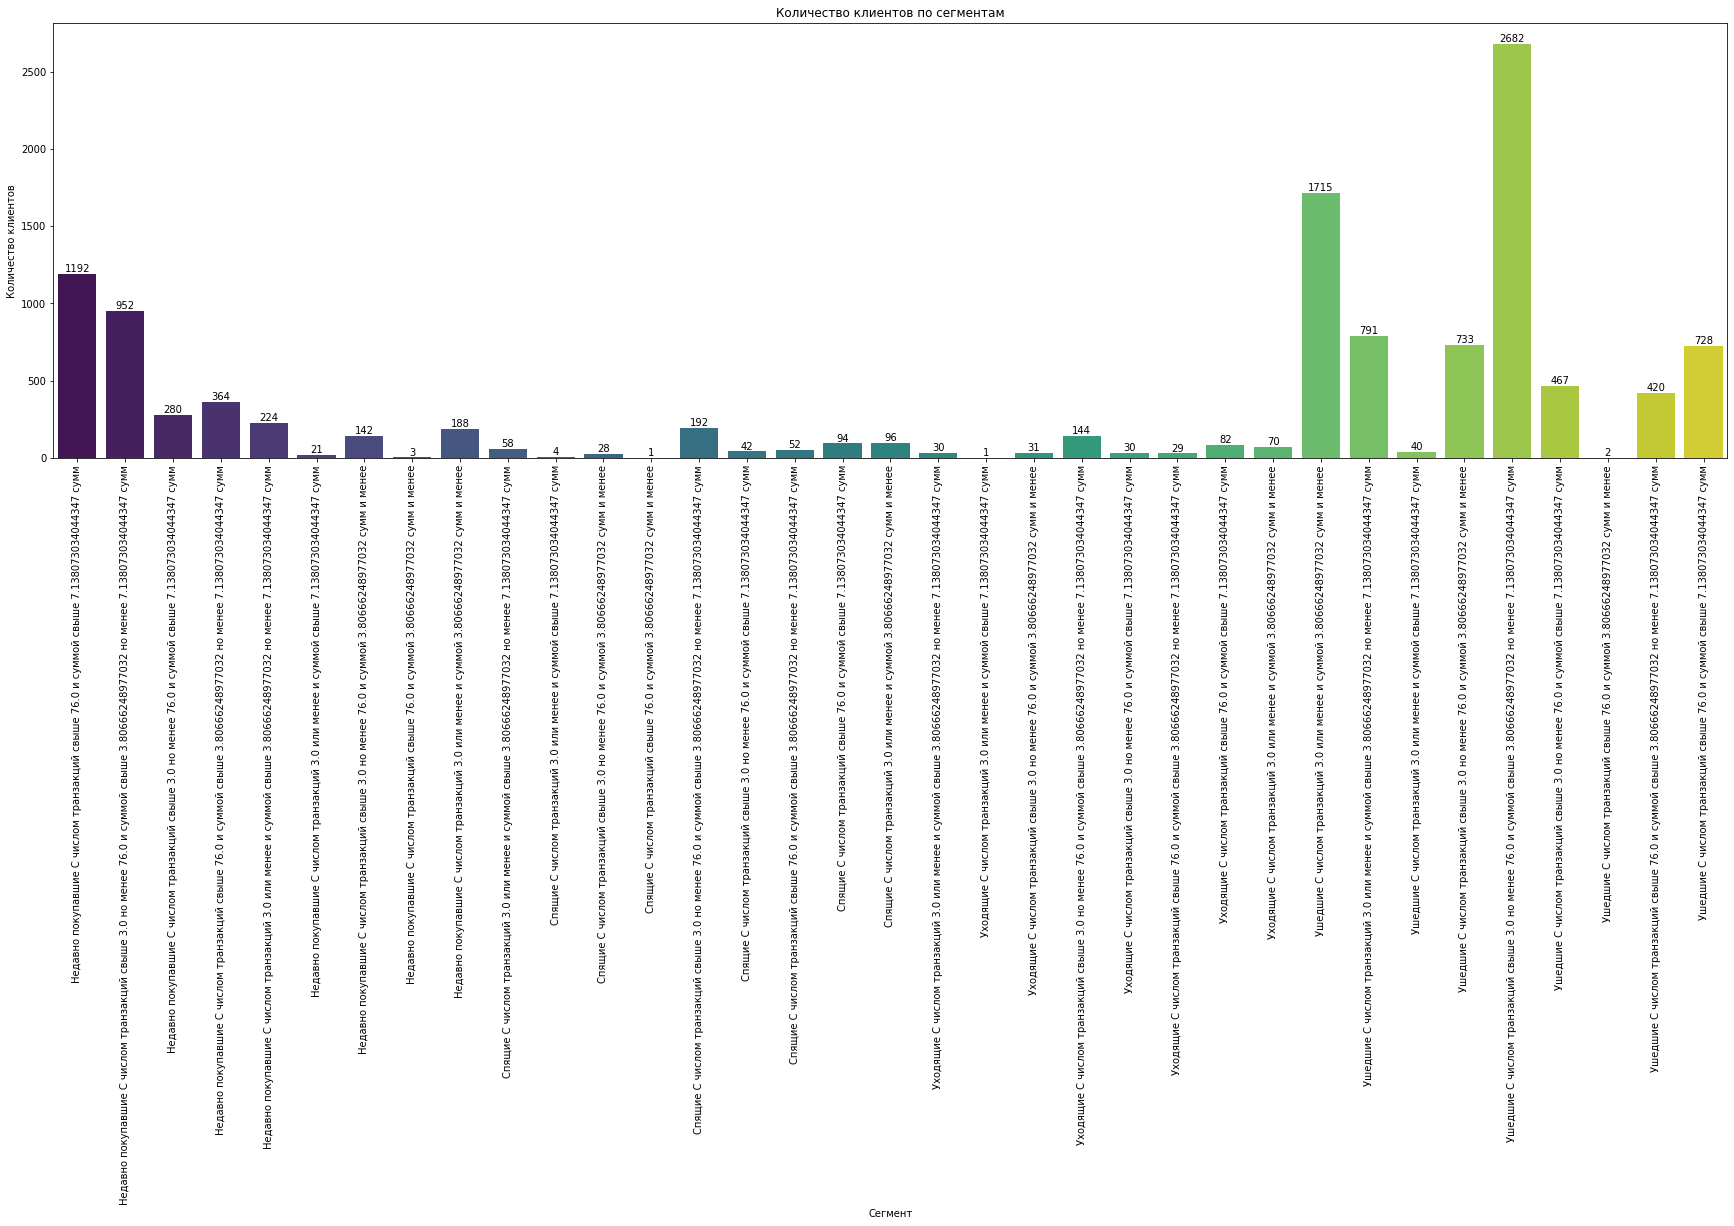

In [50]:
# Визуализация сегментов 

plt.figure(figsize=(30, 8))
ax = sns.barplot(data=rfm_seg, x='segment', y='customers', palette='viridis')
plt.title('Количество клиентов по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=90)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, '%d' % int(height), ha='center', va='bottom')

plt.show()


In [63]:
# Накладываем поверх следующее измерение - тренд транзакционной активности
# выбираем только тех клиентов, у кого есть более 2 месяцев с транзакциями (3 и более точек для построения тренда)

trx_for_trends_cutted_df = trx_for_trends_df[trx_for_trends_df['m_cnt'] > 2]

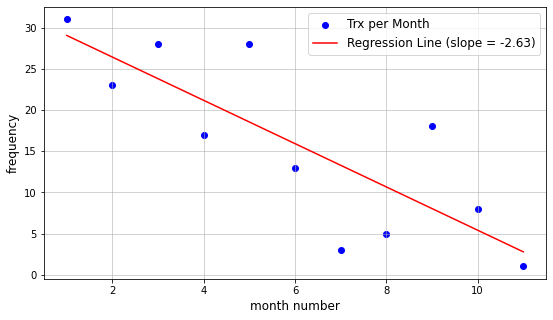

In [64]:
# Скрипт для построения трендов для отдельных клиентов
# Предназначен для тестирования, изучения slope на примерах конкретных пользователей

trx_for_trends_one_client_df = trx_for_trends_cutted_df[trx_for_trends_cutted_df['customer_id'] == '61f372361e099400b08cd252565c922154943a2c3021bd88d13a66ddde62f3b5']

slope, intercept, _, _, _ = linregress(trx_for_trends_one_client_df['m_num'], trx_for_trends_one_client_df['frequency'])
x = np.linspace(trx_for_trends_one_client_df['m_num'].min(), trx_for_trends_one_client_df['m_num'].max(), 100)
y = slope * x + intercept

plt.figure(figsize=(9, 5))
plt.scatter(trx_for_trends_one_client_df['m_num'], trx_for_trends_one_client_df['frequency'], label="Trx per Month", color='blue')
plt.plot(x, y, label=f"Regression Line (slope = {slope:.2f})", color='red')
plt.title("", fontsize=14)
plt.xlabel("month number", fontsize=12)
plt.ylabel("frequency", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.7)
plt.show()

In [65]:
# Построение линий трендов с сохранением угла наклона для каждого клиента 

results = []

for customer_id, group in trx_for_trends_cutted_df.groupby("customer_id"):
    slope, _, _, _, _ = linregress(group['m_num'], group['frequency'])
    results.append({"customer_id": customer_id, "slope": slope})

trx_trend_with_slope_df = pd.DataFrame(results)

In [66]:
trx_trend_with_slope_df.head(2)

,customer_id,slope
0,0000f5bafd7f7516e86afe546004137b3ccba43a14ade7...,-0.800000
1,000bc29afe9eea88a1a6384f1a40b4b9ccb41b283a14d1...,-0.761905


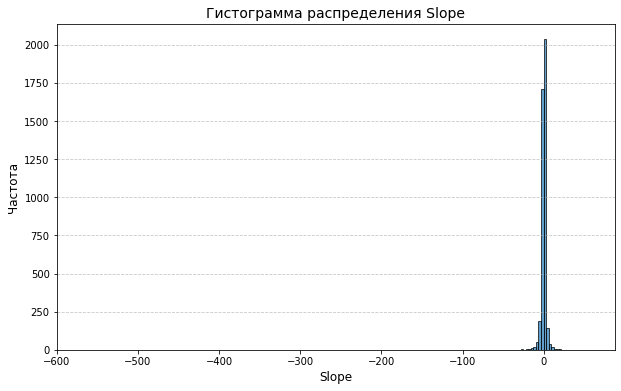

In [67]:
# Занятное изучение распределения наклона, по которому вы можете идентифицировать клиентов с аномальным поведением

plt.figure(figsize=(10, 6))
plt.hist(trx_trend_with_slope_df['slope'], bins=200, edgecolor='black', alpha=0.7)
plt.title("Гистограмма распределения Slope", fontsize=14)
plt.xlabel("Slope", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [73]:
# Присвоение категории для угла наклона.

conditions = [
    trx_trend_with_slope_df["slope"] < -0.1,
    trx_trend_with_slope_df["slope"] > 0.1,
]

choices = ["нисходящий тренд", "восходящий тренд"]

trx_trend_with_slope_df["trend"] = np.select(conditions, choices, default="нейтральный тренд")

In [ ]:
# Объединяем датафреймы с rfm-сегментацией и категории тренда

user_rfm_segm_with_trend_df = pd.merge(trx_trend_with_slope_df[['customer_id', 'trend']],user_rfm_segm_df , on='customer_id', how='left')

In [84]:
columns_to_convert_2 = ['trend', 'Category', 'segment']
user_rfm_segm_with_trend_df[columns_to_convert_2] = user_rfm_segm_with_trend_df[columns_to_convert_2].astype(str)


In [ ]:
user_rfm_segm_with_trend_df['Category_and_trend'] = user_rfm_segm_with_trend_df['Category'] + " - " + user_rfm_segm_with_trend_df['trend']
user_rfm_segm_with_trend_df['segment_and_trend'] = user_rfm_segm_with_trend_df['segment'] + " - " + user_rfm_segm_with_trend_df['trend']

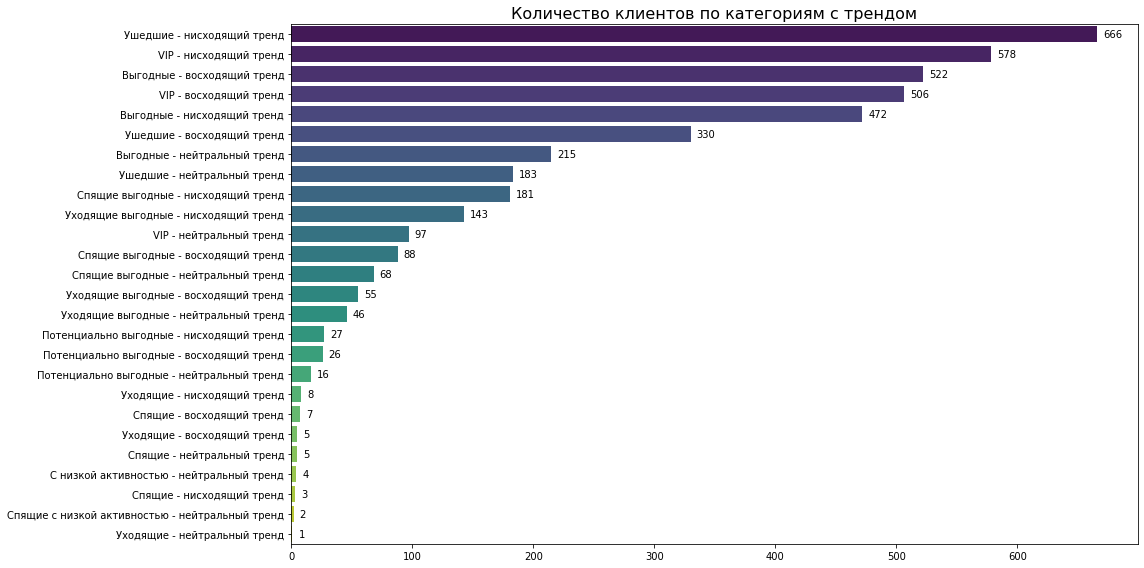

In [ ]:
category_trend_counts = user_rfm_segm_with_trend_df['Category_and_trend'].value_counts().reset_index()
category_trend_counts.columns = ['Category & trend', 'Count']

plt.figure(figsize=(16, 8))
ax = sns.barplot(data=category_trend_counts, y='Category & trend', x='Count', palette='viridis', orient='h')
plt.title('Количество клиентов по категориям с трендом', fontsize=16)
plt.ylabel('', fontsize=12)
plt.xlabel('', fontsize=12)

for p in ax.patches:
    ax.text(p.get_width() + 5, p.get_y() + p.get_height() / 2., '%d' % int(p.get_width()),
            fontsize=10, va='center')

plt.tight_layout()
plt.show()

In [89]:
segment_trend_counts = user_rfm_segm_with_trend_df['segment_and_trend'].value_counts().reset_index()
segment_trend_counts.columns = ['segment_and_trend', 'Count']
segment_trend_counts

,segment_and_trend,Count
0,Недавно покупавшие С числом транзакций свыше 7...,578
1,Недавно покупавшие С числом транзакций свыше 7...,506
2,Недавно покупавшие С числом транзакций свыше 3...,299
3,Недавно покупавшие С числом транзакций свыше 3...,231
4,Ушедшие С числом транзакций свыше 76.0 и суммо...,226
...,...,...
65,Ушедшие С числом транзакций 3.0 или менее и су...,1
66,Недавно покупавшие С числом транзакций свыше 7...,1
67,Недавно покупавшие С числом транзакций 3.0 или...,1
68,Уходящие С числом транзакций свыше 3.0 но мене...,1
